In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Using device: cuda


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from PIL import Image

# Double Conv block used in decoder
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)

# Decoder block with skip connections
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

# U-Net with ResNet34 encoder backbone
class ResNetUNet(nn.Module):
    def __init__(self, num_classes=21):
        super().__init__()
        resnet = models.resnet34(pretrained=True)
        
        # Encoder
        self.encoder1 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu
        )
        self.encoder2 = resnet.layer1  # 64
        self.encoder3 = resnet.layer2  # 128
        self.encoder4 = resnet.layer3  # 256
        self.encoder5 = resnet.layer4  # 512
        
        # Bridge
        self.bridge = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.up1 = DecoderBlock(512, 256, 256)
        self.up2 = DecoderBlock(256, 128, 128)
        self.up3 = DecoderBlock(128, 64, 64)
        self.up4 = DecoderBlock(64, 64, 32)

        # Final classifier
        self.final = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, 1)
        )
        self.upsample_final = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        e1 = self.encoder1(x)   # 1/2
        e2 = self.encoder2(e1)  # 1/4
        e3 = self.encoder3(e2)  # 1/8
        e4 = self.encoder4(e3)  # 1/16
        e5 = self.encoder5(e4)  # 1/32

        b = self.bridge(e5)

        d1 = self.up1(b, e4)
        d2 = self.up2(d1, e3)
        d3 = self.up3(d2, e2)
        d4 = self.up4(d3, e1)

        out = self.final(d4)
        return self.upsample_final(out)

# VOC Dataset class with transforms
class VOCDataset(datasets.VOCSegmentation):
    def __init__(self, root, year='2012', image_set='train', download=True, target_size=256):
        transform = self.get_transform(target_size, is_train=(image_set == 'train'))
        target_transform = self.get_mask_transform(target_size)
        super().__init__(
            root=root, year=year, image_set=image_set, download=download,
            transform=transform, target_transform=target_transform
        )
        
    @staticmethod
    def get_transform(target_size, is_train=True):
        transforms_list = [
            transforms.Resize((target_size, target_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ]
        if is_train:
            transforms_list = [transforms.RandomHorizontalFlip(0.5)] + transforms_list
        return transforms.Compose(transforms_list)
    
    @staticmethod
    def get_mask_transform(target_size):
        return transforms.Compose([
            transforms.Resize((target_size, target_size), interpolation=Image.NEAREST),
            transforms.PILToTensor(),  # Preserves class indices
            transforms.Lambda(lambda x: x.squeeze().long())
        ])
    
    def __getitem__(self, index):
        img, mask = super().__getitem__(index)
        mask[mask == 255] = 21  # VOC border class → ignore index
        return img, mask


In [14]:
# Improved IoU calculation
def calculate_iou(outputs, masks, num_classes=21):
    # Get predictions (outputs are [batch, classes, H, W])
    preds = outputs.argmax(1)
    
    # Filter out ignore index
    valid_mask = (masks != 21)
    preds = preds[valid_mask]
    masks = masks[valid_mask]
    
    # Calculate per-class IoU
    ious = []
    for class_idx in range(num_classes):
        if class_idx == 21:  # Skip ignore class
            continue
            
        pred_class = (preds == class_idx)
        true_class = (masks == class_idx)
        
        intersection = (pred_class & true_class).sum().float()
        union = (pred_class | true_class).sum().float()
        
        if union > 0:
            ious.append((intersection / union).item())
    
    return np.mean(ious) if ious else 0.0

In [24]:
# Training function
def train_model(model, train_loader, val_loader, optimizer, num_epochs=30):
    criterion = nn.CrossEntropyLoss(ignore_index=21)
    best_iou = 0.0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Validation
        model.eval()
        total_iou = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                total_iou += calculate_iou(outputs, masks)
        
        mean_iou = total_iou / len(val_loader)
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss/len(train_loader):.4f} | '
              f'Val mIoU: {mean_iou:.4f}')
        scheduler.step(mean_iou)
        
        # Save best model
        if mean_iou > best_iou:
            best_iou = mean_iou
            torch.save(model.state_dict(), 'best_resnet_unet.pth')
            print(f'Model saved with mIoU: {best_iou:.4f}')
    
    return model

In [29]:
def visualize_results(model, loader):
    model.eval()
    # VOC palette with 22 colors (21 classes + 1 for border)
    palette = np.array([
        [0, 0, 0],        # 0: background
        [128, 0, 0],      # 1: aeroplane
        [0, 128, 0],      # 2: bicycle
        [128, 128, 0],    # 3: bird
        [0, 0, 128],      # 4: boat
        [128, 0, 128],    # 5: bottle
        [0, 128, 128],    # 6: bus
        [128, 128, 128],  # 7: car
        [64, 0, 0],       # 8: cat
        [192, 0, 0],      # 9: chair
        [64, 128, 0],     # 10: cow
        [192, 128, 0],    # 11: dining table
        [64, 0, 128],     # 12: dog
        [192, 0, 128],    # 13: horse
        [64, 128, 128],   # 14: motorbike
        [192, 128, 128],  # 15: person
        [0, 64, 0],       # 16: potted plant
        [128, 64, 0],     # 17: sheep
        [0, 192, 0],      # 18: sofa
        [128, 192, 0],    # 19: train
        [0, 64, 128],     # 20: tv/monitor
        [255, 255, 255]   # 21: border (white)
    ], dtype=np.uint8)
    
    fig, axes = plt.subplots(3, 5, figsize=(25, 15))
    
    # Manually select diverse images (update indices based on your dataset)
    diverse_indices = [7, 42, 88, 123, 167]  # Cars, people, animals, etc
    
    with torch.no_grad():
        for i, idx in enumerate(diverse_indices):
            # Get specific image instead of first in batch
            image, mask = loader.dataset[idx]
            image_tensor = image.unsqueeze(0).to(device)
            
            output = model(image_tensor)
            pred = output.argmax(1).squeeze(0).cpu().numpy()
            
            # Process image
            img = image.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            
            # Process masks - ensure values are within [0, 21]
            true_mask = mask.numpy()
            true_mask = np.clip(true_mask, 0, 21)
            pred = np.clip(pred, 0, 21)
            
            # Apply palette
            true_mask_img = palette[true_mask]
            pred_mask_img = palette[pred]
            
            # Visualize
            axes[0, i].imshow(img)
            axes[0, i].set_title(f'Original {idx}')
            axes[0, i].axis('off')
            
            axes[1, i].imshow(true_mask_img)
            axes[1, i].set_title('Ground Truth')
            axes[1, i].axis('off')
            
            axes[2, i].imshow(pred_mask_img)
            axes[2, i].set_title('Prediction')
            axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('diverse_results.png', dpi=300)
    plt.show()

In [27]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import transforms
from torch import nn
import os

# Your model and dataset classes should already be defined
# ResNetUNet, VOCDataset

def train_model(model, train_loader, val_loader, optimizer, num_epochs, scheduler=None):
    criterion = nn.CrossEntropyLoss(ignore_index=21)
    best_val_iou = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_iou = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                val_iou += (preds == masks).float().mean().item()

        avg_val_iou = val_iou / len(val_loader)

        if scheduler:
            scheduler.step(avg_val_iou)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_train_loss:.4f} - Val IoU: {avg_val_iou:.4f}")

        # Save best model
        if avg_val_iou > best_val_iou:
            best_val_iou = avg_val_iou
            torch.save(model.state_dict(), "best_model.pth")
            print(" Best model saved!")

    return model

# Main execution
if __name__ == '__main__':
    # Parameters
    BATCH_SIZE = 8
    num_epochs = 100
    LR = 1e-4
    TARGET_SIZE = 256

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset
    print(" Loading dataset...")
    train_dataset = VOCDataset('./data', image_set='train', target_size=TARGET_SIZE)
    val_dataset = VOCDataset('./data', image_set='val', target_size=TARGET_SIZE)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Model init
    model = ResNetUNet(num_classes=21).to(device)
    print(f"📦 Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=3,
        verbose=True
    )

    # Train
    print(" Starting training...")
    model = train_model(model, train_loader, val_loader, optimizer, num_epochs, scheduler)


 Loading dataset...
📦 Model parameters: 26,713,525
 Starting training...
Epoch [1/100] - Loss: 2.5461 - Val IoU: 0.4472
 Best model saved!
Epoch [2/100] - Loss: 2.0873 - Val IoU: 0.4987
 Best model saved!
Epoch [3/100] - Loss: 1.8559 - Val IoU: 0.6429
 Best model saved!
Epoch [4/100] - Loss: 1.6574 - Val IoU: 0.6820
 Best model saved!
Epoch [5/100] - Loss: 1.5150 - Val IoU: 0.6583
Epoch [6/100] - Loss: 1.3729 - Val IoU: 0.7023
 Best model saved!
Epoch [7/100] - Loss: 1.2666 - Val IoU: 0.6948
Epoch [8/100] - Loss: 1.1618 - Val IoU: 0.6777
Epoch [9/100] - Loss: 1.0920 - Val IoU: 0.7276
 Best model saved!
Epoch [10/100] - Loss: 1.0291 - Val IoU: 0.7261
Epoch [11/100] - Loss: 0.9876 - Val IoU: 0.7291
 Best model saved!
Epoch [12/100] - Loss: 0.9428 - Val IoU: 0.7357
 Best model saved!
Epoch [13/100] - Loss: 0.9212 - Val IoU: 0.7387
 Best model saved!
Epoch [14/100] - Loss: 0.8964 - Val IoU: 0.7448
 Best model saved!
Epoch [15/100] - Loss: 0.8511 - Val IoU: 0.7391
Epoch [16/100] - Loss: 0.8

Visualizing results...


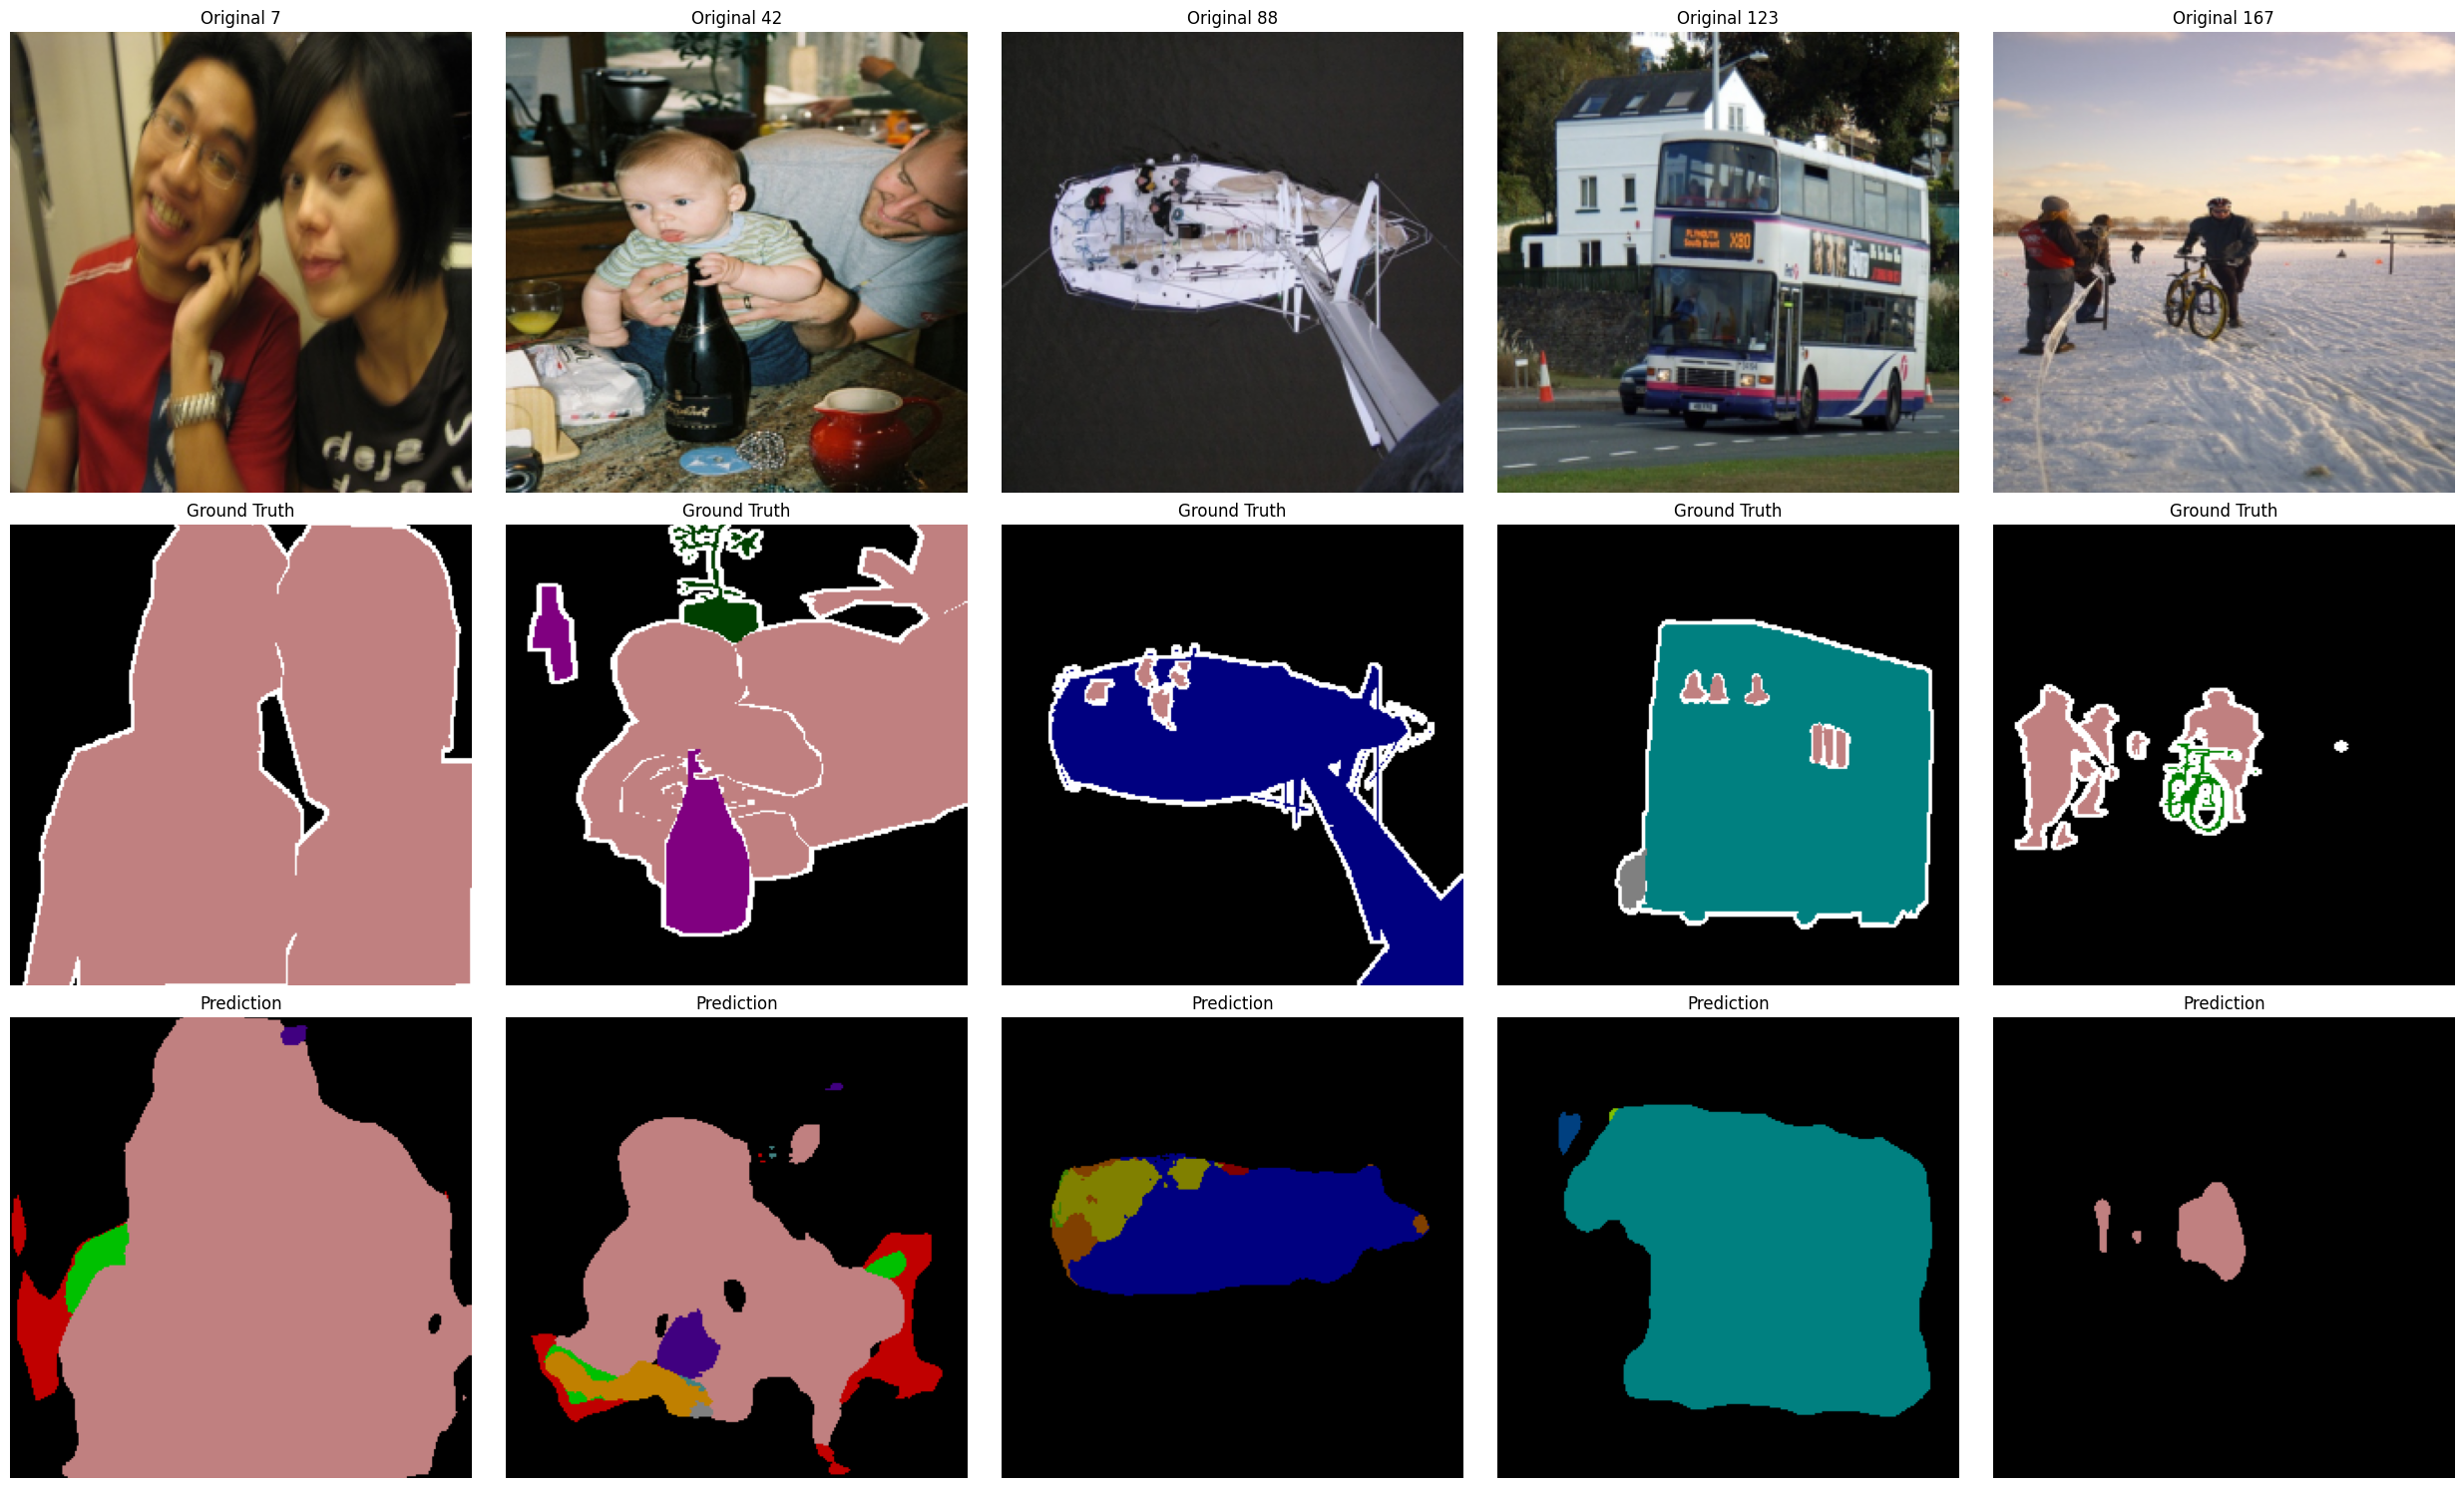

In [31]:
    # Visualize
    print("Visualizing results...")
    visualize_results(model, val_loader)